# sketch2frog: Generating Frogs from Simple Sketches

In [33]:
import matplotlib
import matplotlib.pyplot as plt


## Intro

Introduce the problem:
- inspiration
- why?
- why is this useful - 1-3 channel mapping

Genrative Adversarial Networks (GANs) are class of neural networks which can generate realistic images, video, and audio. 

[deeplearning.ai's GAN Specialisation](https://www.deeplearning.ai/program/generative-adversarial-networks-gans-specialization/)

To conclude my study of GANs I built an image-to-image translation model, sketch2frog, which maps black and white sketches to color photos of frogs. This project is inspired by previous applications such as [edges2cats](https://affinelayer.com/pixsrv/index.html).


The goal of this project is to create a model which can map a human drawn sketch of a frog to a convincing colour image.


Assumptions
    - basic knowledge of GANs (link to an introduction)

## The Dataset

I found a [dataset of over 7000 frogs on a white background](https://github.com/jonshamir/frog-dataset), using these I generated black and white sketch-like images to create a dataset of sketch-image pairs. I could then train a model to map from my generated sketches to the target colour images.

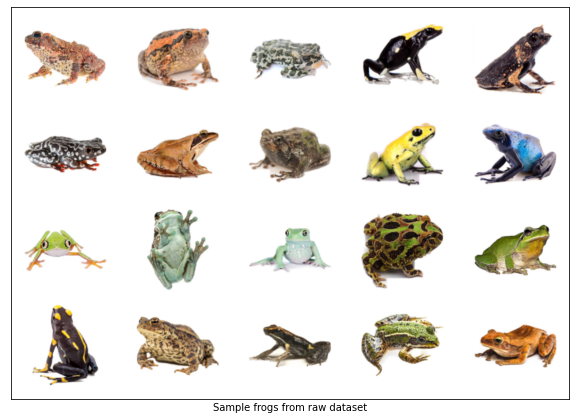

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
ax.imshow(plt.imread("figures/raw-frogs.png"), cmap='gray')
ax.set_xlabel('Sample frogs from raw dataset')
ax.set(xticks=[], yticks=[])
fig.patch.set_facecolor('white')
plt.show()
plt.close()

To create sketches from these images I used a pretrained edge detection model, [DexiNed (Dense Extreme Inception Network)](https://github.com/xavysp/DexiNed/tree/master/DexiNed-TF2). DexiNed is a state-of-the-art CNN based edge detector inspired by the Xception network and HED (Holistically-Nested Edge Detection).

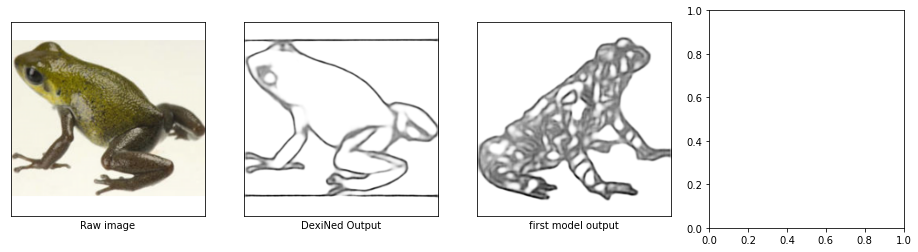

In [73]:
fpaths = ['figures/frog-8/raw.png','figures/frog-8/dexined.png','figures/frog-439/dexined.png']
captions = ['Raw image','DexiNed Output', 'first model output','DexiNed output with too much detail']

fig, axs = plt.subplots(nrows=1, ncols=len(captions), figsize=(SIZE*len(captions),SIZE))
for ax, fpath, caption in zip(axs, fpaths, captions):
    ax.imshow(plt.imread(fpath), cmap='gray')
    ax.set_xlabel(caption)
    ax.set(xticks=[], yticks=[])
    
fig.patch.set_facecolor('white')
plt.show()
plt.close()

DexiNed does a good job of transforming an input frog to a sketch-like image, however it has some problems. DexiNed detects a lot of internal detail resulting in a sketch which is far more complex than a human would draw, it also draws the outlines of shadows and edges of off-white backgrounds. 

While most frogs sit on a white background, many do not or have a large shadow. This proved to be an issue with earlier models resulting in predictions **which did something ike in the above image**

To remove these backgrounds and simplify the sketches I used a U2Net model pretrained for background removal [in this colab](https://colab.research.google.com/github/shreyas-bk/U-2-Net-Demo/blob/master/DEMOS/U_2_Netp_Demonstration_Colab.ipynb#scrollTo=eWxv7eDJiq5b) from [shreyas-bk](https://github.com/shreyas-bk/U-2-Net). In particular this model is U2Netp, a smaller model with 4.7Mb weights, as opposed to the full U2Net with 176.3Mb weights.

U2Net outputs a mask which I applied to the raw image to remove background. I then applied DexiNed to the U2Net masks to get sketches with no internal detail.

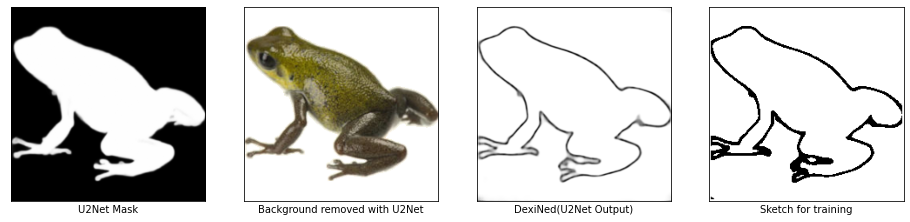

In [72]:
fpaths = ['figures/frog-8/unet.png','figures/frog-8/unet masked.png','figures/frog-8/dexined(u2net output).png','figures/frog-8/outline-sketch.png']
captions = ['U2Net Mask','Background removed with U2Net','DexiNed(U2Net Output)','Sketch for training']
SIZE = 4

fig, axs = plt.subplots(nrows=1, ncols=len(captions), figsize=(SIZE*len(captions),SIZE))
for ax, fpath, caption in zip(axs, fpaths, captions):
    ax.imshow(plt.imread(fpath), cmap='gray')
    ax.set_xlabel(caption)
    ax.set(xticks=[], yticks=[])
    
fig.patch.set_facecolor('white')
plt.show()
plt.close()

These new sketches were far more similar to a hand drawn sketch and while they did occasionally amputate frog limbs, generated frogs no longer had background problems. However, with no internal detail to learn from, models trained with this dataset struggled placing eyes and mouths, omitting them entirely or sometimes placing too many.

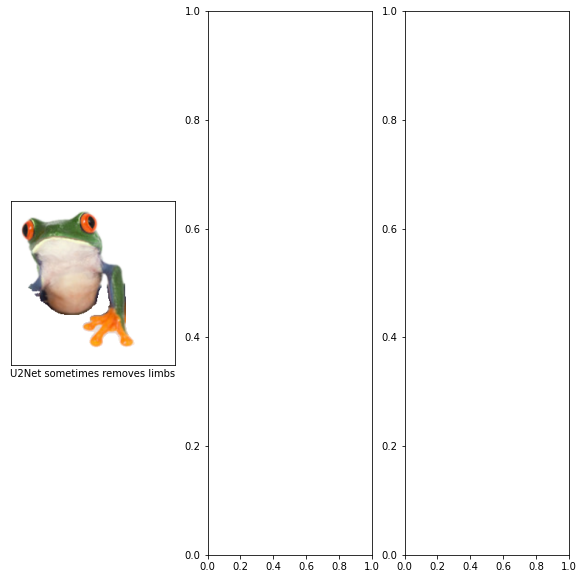

In [64]:
fpaths = ['figures/lost legs.png',]
captions = ['U2Net sometimes removes limbs','No eyes','Too many eyes']

fig, axs = plt.subplots(nrows=1, ncols=len(captions), figsize=(10,10))
for ax, fpath, caption in zip(axs, fpaths, captions):
    ax.imshow(plt.imread(fpath), cmap='gray')
    ax.set_xlabel(caption)
    ax.set(xticks=[], yticks=[])
    
fig.patch.set_facecolor('white')
plt.show()
plt.close()

As a compromise I created a final set of sketches by applying DexiNed to the masked target images, resulting in sketches with no backgrounds but lots of internal detail.

In [ ]:
fpaths = ['figures/lost legs.png',]
captions = ['U2Net sometimes removes limbs','No eyes','Too many eyes']

fig, axs = plt.subplots(nrows=1, ncols=len(captions), figsize=(10,10))
for ax, fpath, caption in zip(axs, fpaths, captions):
    ax.imshow(plt.imread(fpath), cmap='gray')
    ax.set_xlabel(caption)
    ax.set(xticks=[], yticks=[])
    
fig.patch.set_facecolor('white')
plt.show()
plt.close()

## pix2pix: Paired Image-to-Image Translation

[Pix2pix](https://phillipi.github.io/pix2pix/) is a Conditional GAN which takes an image as input and learns to generate a transformation of that image. It consists of a UNet genrator and a PatchGAN discriminator

### UNet Generator

large and small versions for faster iteration

#### Generator Loss Function

### PatchGAN Discriminator

Not actually a GAN, a FCN which takes as input the generator's input and output concatenated along the features diumension

Patch size demo

#### Discriminator Loss Function

## Training

- Label Smoothing
- Least Squares GAN > BCE Loss
- Data Augmentation with Albumentations

## Results

- overfitting without data augmentation
- results of outline sketches
    - small vs. large model
    - small vs. large image size
- best results on validatiuon set
- results on hand drawn
- training gif
- Training graphs + explanation of values

## Conclusion & Further Work

Link to colab 